In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import math
from numpy.random import multinomial, binomial
from scipy.stats import chi2

In [2]:
np.random.seed(0)

# Génération des données naïves

In [148]:
#networks simulation
N = 100
D0 = np.random.randint(2,size=(N,N))
D0 = np.tril(D0) + np.tril(D0, -1).T
D1 = np.random.randint(2,size=(N,N))
D1 = np.tril(D1) + np.tril(D1, -1).T
for i in range(N):
    D0[i,i] = 0
    D1[i,i] = 0

In [149]:
M0 = np.sum(D0,axis=1)
G0 = np.linalg.solve(np.diag(M0),D0)

M1 = np.sum(D1,axis=1)
G1 = np.linalg.solve(np.diag(M1),D1)

In [150]:
F0 = (np.dot(D0,D0)>0).astype(np.int)
F1 = (np.dot(D1,D1)>0).astype(np.int)

In [151]:
#GPA simulation
gpa_0 = np.random.uniform(low= 0,high=4,size=N)
gpa_1 = np.random.uniform(low=0,high=4,size=N)

# 1. MLIM model

On fait la régression bayésienne, avec les a posteriori conjugués (inverse-$\chi^2(1)$, normale conditionnelle).

si on veut juste les means et vars, il suffit de les calculer les paramètres des posterior.

In [152]:
#priors 
#on a 4 coefficients beta sur lesquels travailler 
mu0 = np.zeros(4) #mean of the conditional normal distribution 
Q0 = np.diag(np.ones(4)) #var of the conditional normal distribution
a0 = 1 #coef of the inverse gamma
b0 = 1 #scaling coefficient of the inverse gamma

In [153]:
#construction des variables explicatives et variables cibles
Y = gpa_1
Ybar = G1.dot(Y)
X = gpa_0
Xbar = G1.dot(X)
features = np.column_stack((np.ones(len(Y)),Ybar,X,Xbar))

Les paramètres du modèle sont mis à jour selon les équations suivantes :
$$ Q_{n}=(\mathbf {X} ^{\rm {T}}\mathbf {X} + Q_{0}) $$
$$  \boldsymbol\mu_n=(\mathbf{X}^{\rm T}\mathbf{X}+ Q_0)^{-1} (Q_0\boldsymbol\mu_0+\mathbf{X}^{\rm T}\mathbf{y})  $$ 
$$ a_{n}=a_{0}+{\frac  {n}{2}} $$ 
$$ b_{n}=b_{0}+{\frac  {1}{2}}({\mathbf  {y}}^{{{\rm {T}}}}{\mathbf  {y}}+{\boldsymbol  \mu }_{0}^{{{\rm {T}}}}Q_{0}{\boldsymbol  \mu }_{0}-{\boldsymbol  \mu }_{n}^{{{\rm {T}}}}Q_{n}{\boldsymbol  \mu }_{n}) $$

In [154]:
#updating parameters: computing the posterior distribution parameters
Qn = features.T.dot(features) + Q0
mun = np.linalg.solve(Qn,Q0.dot(mu0)+features.T.dot(Y))
an = a0+len(Y)/2
bn = b0 + 0.5*(Y.dot(Y)+mu0.T.dot(Q0.dot(mu0))-mun.T.dot(Qn.dot(mun)))

In [155]:
#moyennes des lois normales a posteriori
mun

array([ 0.96308266, -0.21265666, -0.01211112,  0.64919329])

On obtient donc 
$$ \beta_0 = 1.46 , \beta_{\bar{Y}} = 0.42, \beta_x = 0.16, \beta_{\bar{x}} = -0.35 $$

In [156]:
#matrice de variance covariance
Qn

array([[101.        , 188.38248081, 206.74836504, 205.87696439],
       [188.38248081, 357.12249736, 389.20689229, 387.65238073],
       [206.74836504, 389.20689229, 562.00084368, 426.27945394],
       [205.87696439, 387.65238073, 426.27945394, 426.30258603]])

Pour le $\sigma^2$

In [157]:
bn/(an-1) #moyenne de l'inverse-gamma

1.2291629476769066

In [158]:
bn**2/((an-1)**2*(an-2)) #variance de l'inverse gamma

0.030833501060036364

# 2. Exogenous network formation

$\alpha \sim \mathcal{N}(0,1)$ (chaque \alpha suit une loi normale de façon indépendante)

$\displaystyle{P(D_{1,ij} = 1|D_{0},X)  = (\frac{e^{\alpha_{0} + \alpha_{x}|Xi-Xj| + \alpha_{d}D_{0ij}+ \alpha_{f}F_{0ij}}}{1 + e^{\alpha_{0} + \alpha_{x}|Xi-Xj| + \alpha_{d}D_{0ij}+ \alpha_{f}F_{0ij}}})^2}$



In [159]:
#priors
alpha0 = np.random.randn(1)
alphax = np.random.randn(1)
alphad = np.random.randn(1)
alphaf = np.random.randn(1)

alpha = np.random.randn(4)

In [160]:
#feature engineering 
#we must create |Xi-Xj| for each (i,j) couple 
dist = np.zeros((N,N))
for i in range(N):
    for j in range(i,N):
        value = np.abs(X[i]-X[j])
        dist[i][j] = value
        dist[j][i] = value

In [161]:
#matrix of utilities
U = np.exp(alpha[0]*np.ones((N,N))+alpha[1]*dist+alpha[2]*D0+alpha[3]*F0)

In [162]:
#We create a new D1 matrix based on the probability formula
D1_new = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        p = (U[i,j])/(1 + U[i,j])
        D1_new[i,j] = np.random.binomial(1,p**2)

In [163]:
def posterior(a,x,theta):
    """
    parameters
    ----------
    a: array of alpha parameters
    x: D1 
    theta: array [np.ones,(|Xi-Xj|),D0,F0]
    """
    N = x.shape[0]
    res = np.exp(-0.5*a.dot(a))**(N*(N-1)*0.5)
    for i in range(N):
        for j in range(i+1,N):
            #compute <alpha,theta>
            ps = 0
            for k in range(4):
                ps += a[k]*theta[k][i,j] 
            res *= np.exp(2*x[i,j]*ps)
    return res

In [164]:
#Metropolis Hastings with normal kernel 
theta = [np.ones((N,N)),dist,D0,F0]
alpha_list = [alpha]
n_iter = 1000
for i in range(n_iter): 
    y = alpha + np.random.randn(4)
    ratio = posterior(y,D1,theta)/posterior(alpha,D1,theta)*1 #1 is the kernel ratio term 
    p_accept = min([1,ratio])
    b = binomial(1,p_accept)
    alpha = b*y+(1-b)*alpha
    alpha_list.append(alpha)

C:\Users\benoit\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


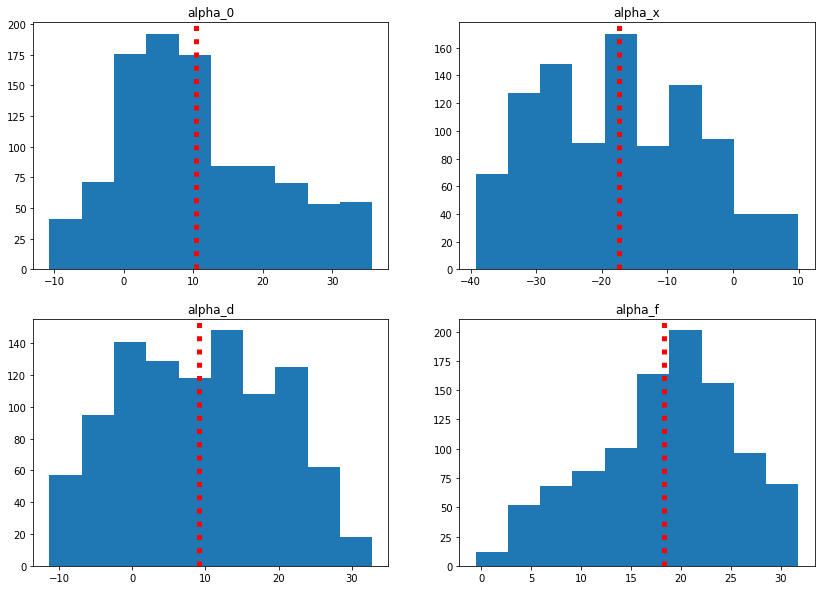

In [165]:
fig = plt.figure(figsize=(14,10))
titles = ['alpha_0','alpha_x','alpha_d','alpha_f']
for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    alpha0 = [a[i] for a in alpha_list]
    ax.hist(alpha0)
    ax.set_title(titles[i])
    ax.axvline(np.mean(alpha0),ls='dotted',c='r',linewidth = 5)
plt.show()

In [166]:
df = pd.DataFrame([],index=['a0','ax','ad','af'],columns = ['mean','std'])
for i in range(4):
    alpha0 = [a[i] for a in alpha_list]
    df.iloc[i,:] = [np.mean(alpha0),np.std(alpha0)]
df

,mean,std
a0,10.3874,10.7954
ax,-17.3166,12.0272
ad,9.10197,10.4149
af,18.3272,7.07315


In [167]:
alphas = df['mean'].values

# 3. Endogenous network formation

In [168]:
betas = mun #results from 1st part
beta_cov_mat = Qn #from the first part
alphas = [np.mean(a)/1e10 for a in alpha_list] #results from 2nd part
alphas = np.zeros(4)
beta_xi = 0.1*np.random.randn(1) #normal with variance 0.01
alpha_xi = -1 + 0.1*np.random.randn(1) #N(-1,0.01)
xi = binomial(1,0.5,size=N)
xi[0] = 1
sigma2 = 2 #à corriger avec les résultats d'avant 

## update of $\xi_i$

In [169]:
#update of the xi_i
theta = [np.ones((N,N)),dist,D0,F0]
n_iter = 10
for n in range(n_iter):
    probas = []
    for i in range(N):
        #compute binomial parameter
        p0 = 0
        p1 = 0
        for j in range(N):
            for k in range(4):
                p0 += 2*D1[i,j]*alphas[k]*theta[k][i,j]
            p1 += p0
        p0 += 2*alpha_xi*np.sum(D1[i,:].dot(xi))
        p1 += 2*alpha_xi*(N-np.sum(D1[i,:].dot(xi)))
        proba = 1/(1+np.exp(p1-p0))
        probas.append(proba)
        xi[i] = binomial(1,proba)

In [170]:
xi

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1])

## Update of $\beta$

In [171]:
def posterior_endo(b,bxi,sigma2,xi,a,axi,D):
    """
    compute log posterior then go exp 
    b is the beta vector [beta_0,beta_x,beta_ybar,beta_xbar]
    """
    N = D.shape[0]
    res = -0.5*np.linalg.norm(b[:-1]) #prior of beta
    res += -0.5*b[-1]**2/(0.01**2) #prior of beta xi
    res += np.sum([probas[i]*xi[i]+(1-probas[i])*(1-xi[i])]) #prior of xi
    res += chi2.ppf(sigma2,df=10) #prior of sigma2
    res += -0.5*np.linalg.norm(a) #prior of alpha
    res += -0.5*(axi+1)**2/(0.01**2) #prior of alpha_xi
    #compute pi(Y|b) 
    I = np.identity(N)
    A = np.linalg.inv(I-b[2]*G1)
    mean =  b[0]*np.ones(N)+b[1]*X+b[3]*G1.dot(X)+bxi*xi
    mean = A.dot(mean)
    var = sigma2*A.dot(A.T)
    inv_var = I-b[2]*G1
    res += -N/2*np.log(np.linalg.det(var))
    res += -0.5*(Y-mean).T.dot(inv_var).dot(Y-mean)
    
    return res

In [172]:
#update betas 
n_iter = 100
beta_list = [betas]
beta_xi_list = [0]
for i in range(n_iter):
    y = betas + (1/16)*Qn.dot(np.random.randn(4)) #normal centered on previous values with previous cov matrix
    yxi = 0.1*np.random.randn(1)[0]
    #computation of the beta posterior
    pi_prev = posterior_endo(beta_list[-1],beta_xi_list[-1],sigma2,xi,alphas,alpha_xi,D1)
    pi_suiv = posterior_endo(y,beta_xi_list[-1],sigma2,xi,alphas,alpha_xi,D1)
    #computation of ratio 
    ratio = pi_suiv/pi_prev
    inv_Qn = np.linalg.inv(Qn)
    ratio *= np.exp(-0.5*((beta_list[-1]-y).T.dot(inv_Qn).dot(beta_list[-1]-y)+100*(beta_xi_list[-1]-yxi)**2))
    #comparison with 1
    p_accept = min([1,ratio])
    #decision
    if binomial(1,p_accept):
        beta_list.append(y)
        beta_xi_list.append(yxi)
    else: 
        beta_list.append(beta_list[-1])
        beta_xi_list.append(beta_xi_list[-1])
            

C:\Users\benoit\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()


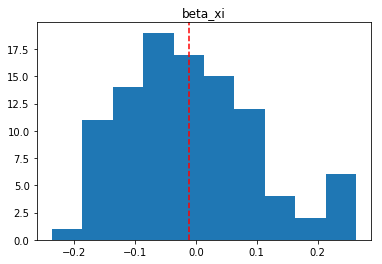

In [173]:
plt.hist(beta_xi_list)
plt.axvline(np.mean(beta_xi_list),ls='--',c='r')
plt.title('beta_xi')
plt.show()

In [174]:
df_beta = pd.DataFrame([],index=['beta0','betax','beta_ybar','beta_xbar','beta_xi'],columns = ['mean','std'])
for i in range(4):
    x1 = np.mean([b[i] for b in beta_list])
    x2 = np.std([b[i] for b in beta_list])
    df_beta.iloc[i] = [x1,x2]
df_beta.iloc[4] = [np.mean(beta_xi_list),np.std(beta_xi_list)]
df_beta

,mean,std
beta0,2.81327,19.3739
betax,3.28408,36.5017
beta_ybar,3.47453,44.6367
beta_xbar,4.47353,39.928
beta_xi,-0.0120865,0.108506


In [175]:
betas = df_beta['mean'].values

## Update $\sigma^2$

Gibbs sampling

In [176]:
sigma2_list = []
for k in range(100):
    invchi2 = chi2.ppf(np.random.rand(),df=10)
    I = np.identity(N)
    A = np.linalg.inv(I-betas[2]*G1)
    mu_y = betas[0]*np.ones(N)+betas[1]*X+betas[3]*G1.dot(X)+betas[4]*xi
    mu_y = A.dot(mu_y)
    var = np.matmul(I-betas[2]*G1,I-betas[2]*G1)
    tau2 =  (1/11)*(Y-mu_y).dot(var.dot(Y-mu_y))
    sigma2 = invchi2/(11*tau2)
    sigma2_list.append(sigma2)

In [177]:
sigma2 = np.mean(sigma2_list)
sigma2

0.00019423113164665194

## Update $\alpha$

We use the same Metropolis-Hastings algorithm as previously with slight changes to take into account the $\xi$ variable.

In [178]:
alphas = np.append(alphas,alpha_xi)

In [179]:
def alpha_posterior_endo(a,x,theta):
    """
    parameters
    ----------
    a: array of alpha parameters
    x: D1 
    theta: array [np.ones,(|Xi-Xj|),D0,F0,xi]
    """
    N = x.shape[0]
    res = np.exp(-0.5*a.dot(a))**(N*(N-1)*0.5)
    for i in range(N):
        for j in range(i+1,N):
            #compute <alpha,theta>
            ps = 0
            for k in range(5):
                ps += a[k]*theta[k][i,j] 
            res *= np.exp(2*x[i,j]*ps)
    return res

In [180]:
#Metropolis Hastings with normal kernel 
theta = [np.ones((N,N)),dist,D0,F0,xi]
alpha_list = [alphas]
n_iter = 1000
for i in range(n_iter): 
    y = alphas + np.random.randn(5)
    ratio = posterior(y,D1,theta)/posterior(alphas,D1,theta)*1 #1 is the kernel ratio term 
    p_accept = min([1,ratio])
    b = binomial(1,p_accept)
    alphas = b*y+(1-b)*alphas
    alpha_list.append(alphas)

C:\Users\benoit\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


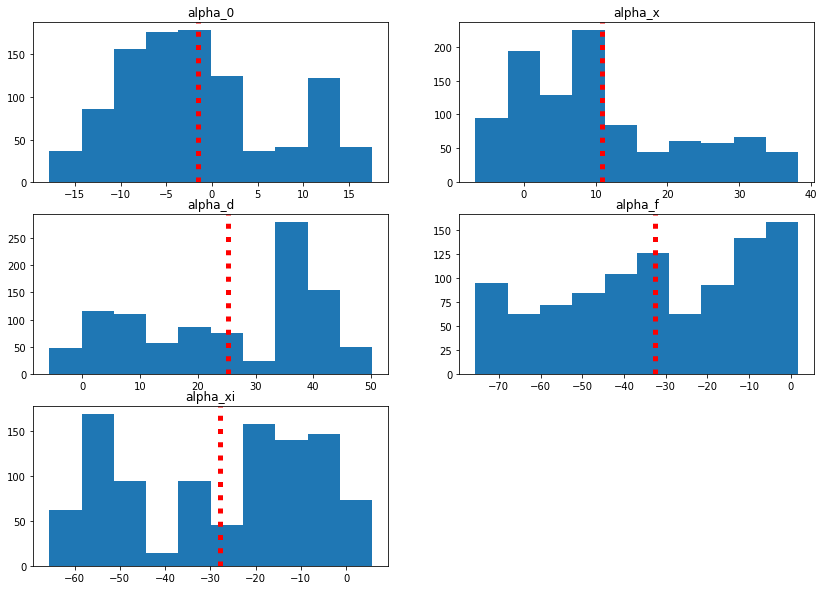

In [181]:
fig = plt.figure(figsize=(14,10))
titles = ['alpha_0','alpha_x','alpha_d','alpha_f','alpha_xi']
for i in range(5):
    ax = fig.add_subplot(3,2,i+1)
    alpha0 = [a[i] for a in alpha_list]
    ax.hist(alpha0)
    ax.set_title(titles[i])
    ax.axvline(np.mean(alpha0),ls='dotted',c='r',linewidth = 5)
plt.show()

In [182]:
df = pd.DataFrame([],index=['a0','ax','ad','af','a_xi'],columns = ['mean','std'])
for i in range(5):
    alpha0 = [a[i] for a in alpha_list]
    df.iloc[i,:] = [np.mean(alpha0),np.std(alpha0)]
df

,mean,std
a0,-1.54581,8.3872
ax,10.8273,11.4565
ad,25.1918,15.4321
af,-32.4901,22.8391
a_xi,-27.8558,20.728


In [183]:
alphas = df['mean'].values

## Update $\xi$

In [184]:
n_iter = 100
for n in range(n_iter):
    probas = []
    for i in range(N):
        #compute binomial parameter
        p0 = 0
        p1 = 0
        for j in range(N):
            for k in range(4):
                p0 += 2*D1[i,j]*alphas[k]*theta[k][i,j]
            p1 += p0
        p0 += 2*alphas[4]*np.sum(D1[i,:].dot(xi))
        p1 += 2*alphas[4]*(N-np.sum(D1[i,:].dot(xi)))
        proba = 1/(1+np.exp(p1-p0))
        probas.append(proba)
        xi[i] = binomial(1,proba)

C:\Users\benoit\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  


In [185]:
xi

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Nos valeurs n'ont pas forcément de sens: tout a été sélectionné au hasard

# 4. Heterogeneity in peer effects

On utilise une matrice de réseau à l'étpae 1 qui n'est plus symétrique (i ami de j n'implique pas j ami de i)  

In [186]:
D1 = np.random.randint(2,size=(N,N))
D0 = np.random.randint(2,size=(N,N))

Same as 1. with different networks and extended models

In [187]:
def heterogeneity(name):
    """
    réalise les estimations de la partie MLIM avec d'autres réseaux 
    parameters
    ----------
    name : définition du réseau utilisée
    
    returns
    -------
    df : pd.DataFrame contenant les means et vars pour beta et sigma2
    """
    
    if name=='lagged':
        DB = D0 * (1 - D1)
    elif name =='mutual':
        DB = np.asarray([[D1[i,j]==D1[j,i] for j in range(N)] for i in range(N)])
    elif name=='fof': #friends of friends
        DM = np.asarray([[D1[i,j]==D1[j,i] for j in range(N)] for i in range(N)])
        FM = (np.dot(DM,DM)>0).astype(np.int)
        DB = (1 - D1) * FM
    else: 
        raise ValueError(name + ' is not a correct network specification')
    #priors 
    #on a 6 coefficients beta sur lesquels travailler 
    mu0 = np.zeros(6) #mean of the conditional normal distribution 
    Q0 = np.diag(np.ones(6)) #var of the conditional normal distribution
    a0 = 1 #coef of the inverse gamma
    b0 = 1 #scaling coefficient of the inverse gamma

    #construction du réseau B
    MB = np.sum(DB,axis=1)
    GB = np.linalg.solve(np.diag(MB),DB)
    #construction des variables explicatives et variables cibles
    Y = gpa_1
    X = gpa_0
    YbarA = G1.dot(Y)
    XbarA = G1.dot(X)
    YbarB = GB.dot(Y)
    XbarB = GB.dot(X)
    features = np.column_stack((np.ones(len(Y)),X,YbarA,XbarA,YbarB,XbarB))

    #updating parameters: computing the posterior distribution parameters
    Qn = features.T.dot(features) + Q0
    mun = np.linalg.solve(Qn,Q0.dot(mu0)+features.T.dot(Y))
    an = a0+len(Y)/2
    bn = b0 + 0.5*(Y.dot(Y)+mu0.T.dot(Q0.dot(mu0))-mun.T.dot(Qn.dot(mun)))
    
    
    df = pd.DataFrame([],index=['beta0','betax','beta_ybarA','beta_xbarA','beta_ybarB','beta_xbarB','sigma2'],columns = ['mean','std'])
    for i in range(6):
        x1 = mun[i]
        x2 = np.sqrt(Qn[i,i])
        df.iloc[i] = [x1,x2]
    
    df.iloc[6] = [bn/(an-1),np.sqrt(bn**2/((an-1)**2*(an-2)))]
    print(df)
    
    return df  

In [188]:
df_lagged = heterogeneity('lagged')

                 mean       std
beta0        0.649565   10.0499
betax      -0.0309515   23.7066
beta_ybarA  -0.508023   18.8977
beta_xbarA   0.373259   20.6471
beta_ybarB   0.303615   19.0755
beta_xbarB   0.437024   20.8309
sigma2        1.20898  0.172711


In [189]:
df_mutual = heterogeneity('mutual')

                 mean       std
beta0        0.537244   10.0499
betax       -0.047651   23.7066
beta_ybarA  -0.663414   18.8977
beta_xbarA   0.288513   20.6471
beta_ybarB  0.0862561   18.8437
beta_xbarB   0.942752   20.5694
sigma2        1.19902  0.171288


In [190]:
df_fof = heterogeneity('fof')

                 mean       std
beta0        0.473895   10.0499
betax      -0.0271527   23.7066
beta_ybarA  -0.732753   18.8977
beta_xbarA   0.238649   20.6471
beta_ybarB   0.133906   18.6955
beta_xbarB    1.01594   20.7306
sigma2        1.19487  0.170696


# 5. Auto-regressive and moving average

## Auto-regressive models

In [191]:
#priors 
#on a 4 coefficients gamma sur lesquels travailler 
mu0 = np.zeros(4) #mean of the conditional normal distribution 
Q0 = np.diag(np.ones(4)) #var of the conditional normal distribution

#construction des variables explicatives et variables cibles
Y = gpa_1
X = gpa_0
GX = G1.dot(X)
GGX = G1.dot(GX)
features = np.column_stack((np.ones(len(Y)),X,GX,GGX))

#updating parameters: computing the posterior distribution parameters
Qn = features.T.dot(features) + Q0
mun = np.linalg.solve(Qn,Q0.dot(mu0)+features.T.dot(Y))

In [192]:
df = pd.DataFrame([],index=['gamma0','gammaX','gamma1','gamma2'],columns = ['mean','std'])
for i in range(4):
    x1 = mun[i]
    x2 = np.sqrt(Qn[i,i])
    df.iloc[i] = [x1,x2]
df

,mean,std
gamma0,0.369063,10.0499
gammaX,-0.0248433,23.7066
gamma1,0.176502,20.6471
gamma2,0.582405,20.6093


In [193]:
bx = df['mean']['gammaX']
bybar = df['mean']['gamma2']/df['mean']['gamma1']
bxbar = df['mean']['gamma1'] - bx * bybar
b0 = (I - bybar*G1).dot(df['mean']['gamma0']*np.ones(N))[0]

In [194]:
df = pd.DataFrame([],index=['beta0','betaX','beta_xbar','beta_FIC'],columns = ['mean'])
df['mean']['beta0'] = b0
df['mean']['betaX'] = bx
df['mean']['beta_xbar'] = bxbar
df['mean']['beta_FIC'] = bybar

df

,mean
beta0,-0.848738
betaX,-0.0248433
beta_xbar,0.258478
beta_FIC,3.29971


## Mobile average

# Application à une autre base

Note entre 0 et 5 attribuée

In [100]:
n_clusters = 5
pop = 100
N = 100
cluster_attribution = np.random.randint(n_clusters,size=pop)
means1 = (4 - (1))*np.random.random_sample(n_clusters) + (1)
means2 = means1 + 0.05*np.random.randn(n_clusters)

In [101]:
prox = np.random.rand(N,N)
prox = np.tril(prox) + np.tril(prox, -1).T
prox*=0.05

In [102]:
norm = np.random.randn(pop,2)
X,Y = norm[:,0],norm[:,1]
for k in range(pop):
    i = cluster_attribution[k]
    Y[k] = means2[i]+ 0.4*Y[k]
    X[k] = means1[i]+ 0.3*X[k]

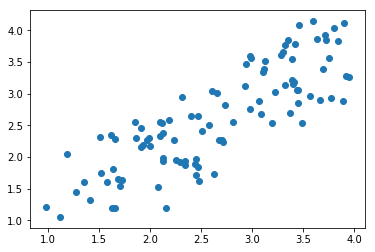

In [103]:
plt.scatter(X,Y)

In [110]:
N = pop
D0 = np.zeros((N,N))
D1 = np.zeros((N,N))
for i in range(N):
    for j in range(i,N):
        if cluster_attribution[i]==cluster_attribution[j]:
            proba = 0.2
        else: 
            proba = prox[cluster_attribution[i],cluster_attribution[j]]
        f0 = binomial(1,proba)
        f1 = binomial(1,proba)
        D0[i,j] = f0
        D0[j,i] = f0
        D1[i,j] = f1
        D1[j,i] = f1

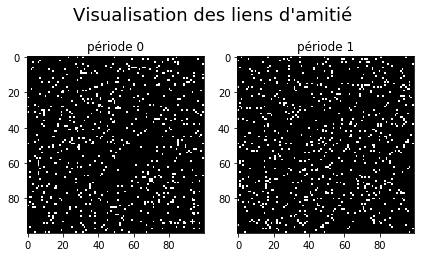

In [111]:
fig,(ax1,ax2) = plt.subplots(1,2)
ax1.imshow(D0,cmap='gray')
ax1.set_title('période 0')
ax2.imshow(D1,cmap='gray')
ax2.set_title('période 1')
fig.suptitle("Visualisation des liens d'amitié",fontsize=18)
plt.tight_layout()
plt.show()

Application du code à la nouvelle base

In [112]:
M0 = np.sum(D0,axis=1)
G0 = np.linalg.solve(np.diag(M0),D0)
M1 = np.sum(D1,axis=1)
G1 = np.linalg.solve(np.diag(M1),D1)
F0 = (np.dot(D0,D0)>0).astype(np.int)
F1 = (np.dot(D1,D1)>0).astype(np.int)

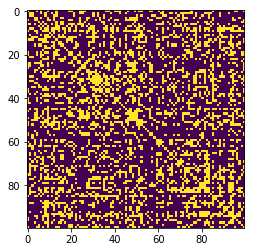

In [113]:
plt.imshow(F0)

## Statistiques descriptives

In [114]:
df = pd.DataFrame([],index=['Y','X',"nombre d'amis 1","nombre d'amis 2"],columns = ['mean','std','min','max'])
df.loc['Y'] = [np.mean(Y),np.std(Y),np.min(Y),np.max(Y)]
df.loc['X'] = [np.mean(X),np.std(X),np.min(X),np.max(X)]
nbamis1 = np.sum(D0,axis=1)
nbamis2 = np.sum(D1,axis=1)
df.loc["nombre d'amis 1"] = [np.mean(nbamis1),np.std(nbamis1),np.min(nbamis1),np.max(nbamis1)]
df.loc["nombre d'amis 2"] = [np.mean(nbamis2),np.std(nbamis2),np.min(nbamis2),np.max(nbamis2)]
df

,mean,std,min,max
Y,2.61605,0.790604,1.05318,4.14599
X,2.64943,0.783067,0.987126,3.94929
nombre d'amis 1,6.49,2.60958,1,15
nombre d'amis 2,7,2.72029,2,14


## Modèle LIM

In [115]:
#a priori
#on a 4 coefficients beta sur lesquels travailler 
mu0 = np.zeros(4) #moyenne de la gaussienne conditionnelle
Q0 = np.diag(np.ones(4)) #variance de la gaussienne conditionnelle
a0 = 1 #coefficient de l'inverse gamma
b0 = 1 #coefficient d'échelle de l'inverse gamma

In [116]:
#construction des variables explicatives et variables cibles
Ybar = G1.dot(Y)
Xbar = G1.dot(X)
features = np.column_stack((np.ones(len(Y)),Ybar,X,Xbar))

In [117]:
#mise à jour des paramètres: calcul des distributions a posteriori
Qn = features.T.dot(features) + Q0
mun = np.linalg.solve(Qn,Q0.dot(mu0)+features.T.dot(Y))
invQn = np.linalg.solve(Qn,np.identity(4))
an = a0+len(Y)/2
bn = b0 + 0.5*(Y.dot(Y)+mu0.T.dot(Q0.dot(mu0))-mun.T.dot(Qn.dot(mun)))

In [118]:
#moyennes des lois normales a posteriori
df = pd.DataFrame([],index=['beta0','beta_ybar','beta_x','beta_xbar'],columns = ['mean','std'])
stds = [np.sqrt(invQn[i,i]) for i in range(len(Qn))]
df['mean'] = mun
df['std'] = stds
df

,mean,std
beta0,-0.139118,0.484909
beta_ybar,0.129077,0.483431
beta_x,0.568951,0.222331
beta_xbar,0.338794,0.483243


In [119]:
#matrice de variance covariance
Qn

array([[101.        , 263.91367165, 264.94264359, 268.16019922],
       [263.91367165, 723.97944612, 732.60843384, 732.76045872],
       [264.94264359, 732.60843384, 764.26538554, 743.89539159],
       [268.16019922, 732.76045872, 743.89539159, 746.53086674]])

In [120]:
print(f"Moyenne de sigma2: {bn/(an-1):.2f}")
print(f"Variance de sigma2: {bn**2/((an-1)**2*(an-2)):.2f}")

Moyenne de sigma2: 0.20
Variance de sigma2: 0.00


Pour les commentaires sur les valeurs, voir le rapport joint.

## Modèle exogène

In [121]:
#a priori 
alpha0 = np.random.randn(1)
alphax = np.random.randn(1)
alphad = np.random.randn(1)
alphaf = np.random.randn(1)
alpha = np.random.randn(4)

In [122]:
#feature engineering 
#we must create |Xi-Xj| for each (i,j) couple 
dist = np.zeros((N,N))
for i in range(N):
    for j in range(i,N):
        value = np.abs(X[i]-X[j])
        dist[i][j] = value
        dist[j][i] = value

In [123]:
#matrix of utilities
U = np.exp(alpha[0]*np.ones((N,N))+alpha[1]*dist+alpha[2]*D0+alpha[3]*F0)

In [124]:
#We create a new D1 matrix based on the probability formula
D1_new = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        p = (U[i,j])/(1 + U[i,j])
        D1_new[i,j] = np.random.binomial(1,p**2)

In [125]:
def posterior(a,x,theta):
    """
    parameters
    ----------
    a: array of alpha parameters
    x: D1 
    theta: array [np.ones,(|Xi-Xj|),D0,F0]
    """
    N = x.shape[0]
    res = np.exp(-0.5*a.dot(a))**(N*(N-1)*0.5)
    for i in range(N):
        for j in range(i+1,N):
            #compute <alpha,theta>
            ps = 0
            for k in range(4):
                ps += a[k]*theta[k][i,j] 
            res *= np.exp(2*x[i,j]*ps)
    return res

In [126]:
#Metropolis Hastings with normal kernel 
theta = [np.ones((N,N)),dist,D0,F0]
alpha_list = [alpha]
n_iter = 1000
for i in range(n_iter): 
    y = alpha + np.random.randn(4)
    ratio = posterior(y,D1,theta)/posterior(alpha,D1,theta)*1 #1 is the kernel ratio term 
    p_accept = min([1,ratio])
    b = binomial(1,p_accept)
    alpha = b*y+(1-b)*alpha
    alpha_list.append(alpha)

C:\Users\benoit\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


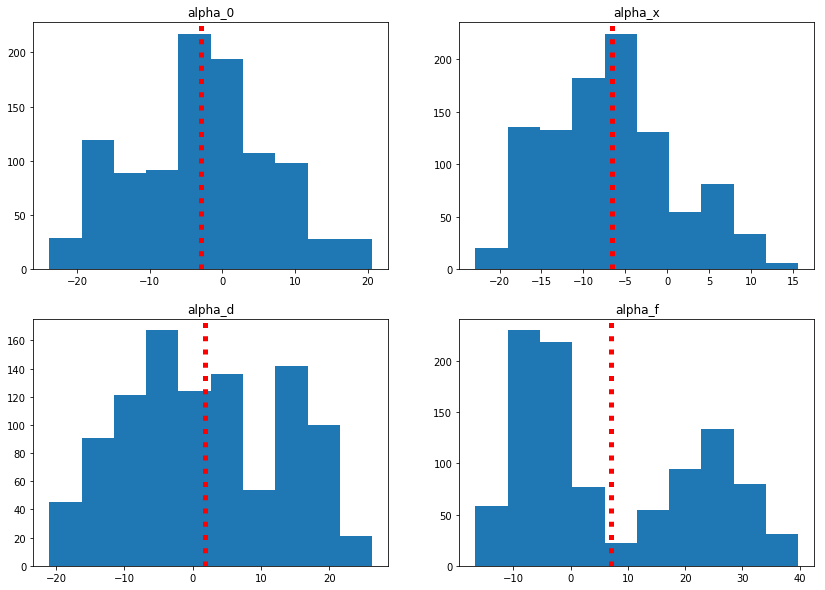

In [127]:
fig = plt.figure(figsize=(14,10))
titles = ['alpha_0','alpha_x','alpha_d','alpha_f']
for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    alpha0 = [a[i] for a in alpha_list]
    ax.hist(alpha0)
    ax.set_title(titles[i])
    ax.axvline(np.mean(alpha0),ls='dotted',c='r',linewidth = 5)
plt.show()

In [128]:
df = pd.DataFrame([],index=['a0','ax','ad','af'],columns = ['mean','std'])
for i in range(4):
    alpha0 = [a[i] for a in alpha_list]
    df.iloc[i,:] = [np.mean(alpha0),np.std(alpha0)]
df

,mean,std
a0,-2.9479,9.47249
ax,-6.57843,7.55597
ad,1.75097,11.374
af,7.06914,15.4946


In [129]:
alphas = df['mean'].values

## Modèle endogène

In [130]:
betas = mun #results from 1st part
beta_cov_mat = Qn #from the first part
#alphas = [np.mean(a) for a in alpha_list] #results from 2nd part
#alphas = np.zeros(4)
beta_xi = 0.1*np.random.randn(1) #normal with variance 0.01
alpha_xi = -1 + 0.1*np.random.randn(1) #N(-1,0.01)
xi = binomial(1,0.5,size=N)
xi[0] = 1
sigma2 = 2 #à corriger avec les résultats d'avant 

## update of $\xi_i$

In [131]:
#update of the xi_i
theta = [np.ones((N,N)),dist,D0,F0]
n_iter = 10
for n in range(n_iter):
    probas = []
    for i in range(N):
        #compute binomial parameter
        p0 = 0
        p1 = 0
        for j in range(N):
            for k in range(4):
                p0 += 2*D1[i,j]*alphas[k]*theta[k][i,j]
            p1 += p0
        p0 += 2*alpha_xi*np.sum(D1[i,:].dot(xi))
        p1 += 2*alpha_xi*(N-np.sum(D1[i,:].dot(xi)))
        proba = 1/(1+np.exp(p1-p0))
        probas.append(proba)
        xi[i] = binomial(1,proba)

C:\Users\benoit\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()


In [132]:
xi

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])

## Update of $\beta$

In [65]:
def posterior_endo(b,bxi,sigma2,xi,a,axi,D):
    """
    compute log posterior then go exp 
    b is the beta vector [beta_0,beta_x,beta_ybar,beta_xbar]
    """
    N = D.shape[0]
    res = -0.5*np.linalg.norm(b[:-1]) #prior of beta
    res += -0.5*b[-1]**2/(0.01**2) #prior of beta xi
    res += np.sum([probas[i]*xi[i]+(1-probas[i])*(1-xi[i])]) #prior of xi
    res += chi2.ppf(sigma2,df=10) #prior of sigma2
    res += -0.5*np.linalg.norm(a) #prior of alpha
    res += -0.5*(axi+1)**2/(0.01**2) #prior of alpha_xi
    #compute pi(Y|b) 
    I = np.identity(N)
    A = np.linalg.inv(I-b[2]*G1)
    mean =  b[0]*np.ones(N)+b[1]*X+b[3]*G1.dot(X)+bxi*xi
    mean = A.dot(mean)
    var = sigma2*A.dot(A.T)
    inv_var = I-b[2]*G1
    res += -N/2*np.log(np.linalg.det(var))
    res += -0.5*(Y-mean).T.dot(inv_var).dot(Y-mean)
    
    return res

In [66]:
#update betas 
n_iter = 100
beta_list = [betas]
beta_xi_list = [0]
for i in range(n_iter):
    y = betas + (1/16)*Qn.dot(np.random.randn(4)) #normal centered on previous values with previous cov matrix
    yxi = 0.1*np.random.randn(1)[0]
    #computation of the beta posterior
    pi_prev = posterior_endo(beta_list[-1],beta_xi_list[-1],sigma2,xi,alphas,alpha_xi,D1)
    pi_suiv = posterior_endo(y,beta_xi_list[-1],sigma2,xi,alphas,alpha_xi,D1)
    #computation of ratio 
    ratio = pi_suiv/pi_prev
    inv_Qn = np.linalg.inv(Qn)
    ratio *= np.exp(-0.5*((beta_list[-1]-y).T.dot(inv_Qn).dot(beta_list[-1]-y)+100*(beta_xi_list[-1]-yxi)**2))
    #comparison with 1
    p_accept = min([1,ratio])
    #decision
    if binomial(1,p_accept):
        beta_list.append(y)
        beta_xi_list.append(yxi)
    else: 
        beta_list.append(beta_list[-1])
        beta_xi_list.append(beta_xi_list[-1])
            

C:\Users\benoit\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()


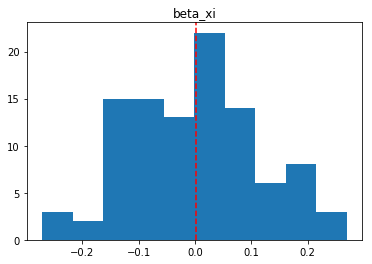

In [67]:
plt.hist(beta_xi_list)
plt.axvline(np.mean(beta_xi_list),ls='--',c='r')
plt.title('beta_xi')
plt.show()

In [68]:
df_beta = pd.DataFrame([],index=['beta0','betax','beta_ybar','beta_xbar','beta_xi'],columns = ['mean','std'])
for i in range(4):
    x1 = np.mean([b[i] for b in beta_list])
    x2 = np.std([b[i] for b in beta_list])
    df_beta.iloc[i] = [x1,x2]
df_beta.iloc[4] = [np.mean(beta_xi_list),np.std(beta_xi_list)]
df_beta

,mean,std
beta0,3.72124,24.5298
betax,8.61424,53.835
beta_ybar,9.02458,54.9938
beta_xbar,8.41374,53.1034
beta_xi,0.00224627,0.114181


In [69]:
betas = df_beta['mean'].values

## Update $\sigma^2$

Gibbs sampling

In [70]:
sigma2_list = []
for k in range(100):
    invchi2 = chi2.ppf(np.random.rand(),df=10)
    I = np.identity(N)
    A = np.linalg.inv(I-betas[2]*G1)
    mu_y = betas[0]*np.ones(N)+betas[1]*X+betas[3]*G1.dot(X)+betas[4]*xi
    mu_y = A.dot(mu_y)
    var = np.matmul(I-betas[2]*G1,I-betas[2]*G1)
    tau2 =  (1/11)*(Y-mu_y).dot(var.dot(Y-mu_y))
    sigma2 = invchi2/(11*tau2)
    sigma2_list.append(sigma2)

In [71]:
sigma2 = np.mean(sigma2_list)
sigma2

3.112952911467362e-05

## Update $\alpha$

We use the same Metropolis-Hastings algorithm as previously with slight changes to take into account the $\xi$ variable.

In [72]:
alphas = np.append(alphas,alpha_xi)

In [73]:
def alpha_posterior_endo(a,x,theta):
    """
    parameters
    ----------
    a: array of alpha parameters
    x: D1 
    theta: array [np.ones,(|Xi-Xj|),D0,F0,xi]
    """
    N = x.shape[0]
    res = np.exp(-0.5*a.dot(a))**(N*(N-1)*0.5)
    for i in range(N):
        for j in range(i+1,N):
            #compute <alpha,theta>
            ps = 0
            for k in range(5):
                ps += a[k]*theta[k][i,j] 
            res *= np.exp(2*x[i,j]*ps)
    return res

In [74]:
#Metropolis Hastings with normal kernel 
theta = [np.ones((N,N)),dist,D0,F0,xi]
alpha_list = [alphas]
n_iter = 1000
for i in range(n_iter): 
    y = alphas + np.random.randn(5)
    ratio = posterior(y,D1,theta)/posterior(alphas,D1,theta)*1 #1 is the kernel ratio term 
    p_accept = min([1,ratio])
    b = binomial(1,p_accept)
    alphas = b*y+(1-b)*alphas
    alpha_list.append(alphas)

C:\Users\benoit\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


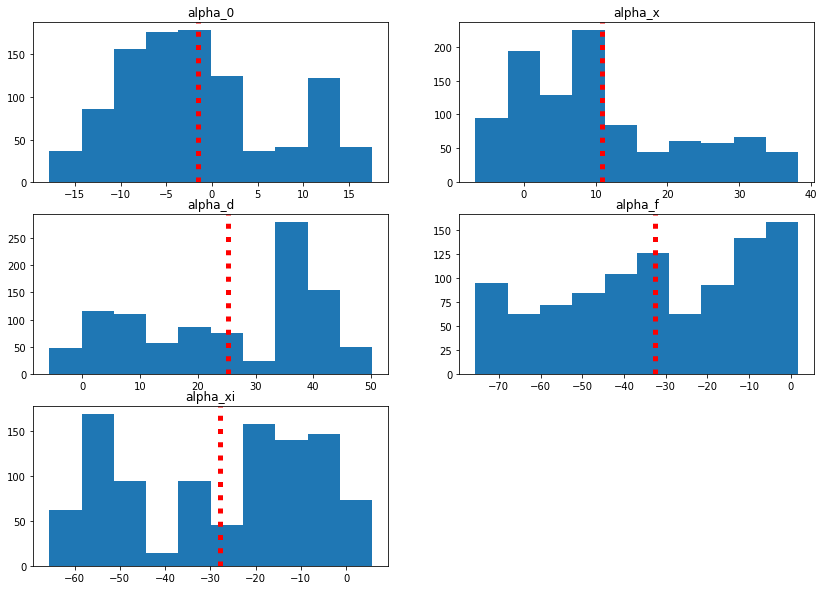

In [197]:
fig = plt.figure(figsize=(14,10))
titles = ['alpha_0','alpha_x','alpha_d','alpha_f','alpha_xi']
for i in range(5):
    ax = fig.add_subplot(3,2,i+1)
    alpha0 = [a[i] for a in alpha_list]
    ax.hist(alpha0)
    ax.set_title(titles[i])
    ax.axvline(np.mean(alpha0),ls='dotted',c='r',linewidth = 5)
plt.show()

In [198]:
df = pd.DataFrame([],index=['a0','ax','ad','af','a_xi'],columns = ['mean','std'])
for i in range(5):
    alpha0 = [a[i] for a in alpha_list]
    df.iloc[i,:] = [np.mean(alpha0),np.std(alpha0)]
df

,mean,std
a0,-1.54581,8.3872
ax,10.8273,11.4565
ad,25.1918,15.4321
af,-32.4901,22.8391
a_xi,-27.8558,20.728


In [199]:
alphas = df['mean'].values

## Update $\xi$

In [200]:
n_iter = 100
for n in range(n_iter):
    probas = []
    for i in range(N):
        #compute binomial parameter
        p0 = 0
        p1 = 0
        for j in range(N):
            for k in range(4):
                p0 += 2*D1[i,j]*alphas[k]*theta[k][i,j]
            p1 += p0
        p0 += 2*alphas[4]*np.sum(D1[i,:].dot(xi))
        p1 += 2*alphas[4]*(N-np.sum(D1[i,:].dot(xi)))
        proba = 1/(1+np.exp(p1-p0))
        probas.append(proba)
        xi[i] = binomial(1,proba)

C:\Users\benoit\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  


In [201]:
xi

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1])

Nos valeurs n'ont pas forcément de sens: tout a été sélectionné au hasard

# 4. Heterogeneity in peer effects

On utilise une matrice de réseau à l'étape 1 qui n'est plus symétrique (i ami de j n'implique pas j ami de i)  

In [139]:
D1 = np.random.randint(2,size=(N,N))
D0 = np.random.randint(2,size=(N,N))

Same as 1. with different networks and extended models

In [140]:
def heterogeneity(name):
    """
    réalise les estimations de la partie MLIM avec d'autres réseaux 
    parameters
    ----------
    name : définition du réseau utilisée
    
    returns
    -------
    df : pd.DataFrame contenant les means et vars pour beta et sigma2
    """
    
    if name=='lagged':
        DB = D0 * (1 - D1)
    elif name =='mutual':
        DB = np.asarray([[D1[i,j]==D1[j,i] for j in range(N)] for i in range(N)])
    elif name=='fof': #friends of friends
        DM = np.asarray([[D1[i,j]==D1[j,i] for j in range(N)] for i in range(N)])
        FM = (np.dot(DM,DM)>0).astype(np.int)
        DB = (1 - D1) * FM
    else: 
        raise ValueError(name + ' is not a correct network specification')
    #priors 
    #on a 6 coefficients beta sur lesquels travailler 
    mu0 = np.zeros(6) #mean of the conditional normal distribution 
    Q0 = np.diag(np.ones(6)) #var of the conditional normal distribution
    a0 = 1 #coef of the inverse gamma
    b0 = 1 #scaling coefficient of the inverse gamma

    #construction du réseau B
    MB = np.sum(DB,axis=1)
    GB = np.linalg.solve(np.diag(MB),DB)
    #construction des variables explicatives et variables cibles
    YbarA = G1.dot(Y)
    XbarA = G1.dot(X)
    YbarB = GB.dot(Y)
    XbarB = GB.dot(X)
    features = np.column_stack((np.ones(len(Y)),X,YbarA,XbarA,YbarB,XbarB))

    #updating parameters: computing the posterior distribution parameters
    Qn = features.T.dot(features) + Q0
    mun = np.linalg.solve(Qn,Q0.dot(mu0)+features.T.dot(Y))
    an = a0+len(Y)/2
    bn = b0 + 0.5*(Y.dot(Y)+mu0.T.dot(Q0.dot(mu0))-mun.T.dot(Qn.dot(mun)))
    
    
    df = pd.DataFrame([],index=['beta0','betax','beta_ybarA','beta_xbarA','beta_ybarB','beta_xbarB','sigma2'],columns = ['mean','std'])
    for i in range(6):
        x1 = mun[i]
        x2 = np.sqrt(Qn[i,i])
        df.iloc[i] = [x1,x2]
    
    df.iloc[6] = [bn/(an-1),np.sqrt(bn**2/((an-1)**2*(an-2)))]
    print(df)
    
    return df  

In [205]:
df_lagged = heterogeneity('lagged')

                 mean       std
beta0        0.649565   10.0499
betax      -0.0309515   23.7066
beta_ybarA  -0.508023   18.8977
beta_xbarA   0.373259   20.6471
beta_ybarB   0.303615   19.0755
beta_xbarB   0.437024   20.8309
sigma2        1.20898  0.172711


In [206]:
df_mutual = heterogeneity('mutual')

                 mean       std
beta0        0.537244   10.0499
betax       -0.047651   23.7066
beta_ybarA  -0.663414   18.8977
beta_xbarA   0.288513   20.6471
beta_ybarB  0.0862561   18.8437
beta_xbarB   0.942752   20.5694
sigma2        1.19902  0.171288


In [207]:
df_fof = heterogeneity('fof')

                 mean       std
beta0        0.473895   10.0499
betax      -0.0271527   23.7066
beta_ybarA  -0.732753   18.8977
beta_xbarA   0.238649   20.6471
beta_ybarB   0.133906   18.6955
beta_xbarB    1.01594   20.7306
sigma2        1.19487  0.170696


# 5. Auto-regressive and moving average

## Auto-regressive models

In [208]:
#priors 
#on a 4 coefficients gamma sur lesquels travailler 
mu0 = np.zeros(4) #mean of the conditional normal distribution 
Q0 = np.diag(np.ones(4)) #var of the conditional normal distribution

#construction des variables explicatives et variables cibles
GX = G1.dot(X)
GGX = G1.dot(GX)
features = np.column_stack((np.ones(len(Y)),X,GX,GGX))

#updating parameters: computing the posterior distribution parameters
Qn = features.T.dot(features) + Q0
mun = np.linalg.solve(Qn,Q0.dot(mu0)+features.T.dot(Y))

In [212]:
df = pd.DataFrame([],index=['gamma0','gammaX','gamma1','gamma2'],columns = ['mean','std'])
for i in range(4):
    x1 = mun[i]
    x2 = np.sqrt(Qn[i,i])
    df.iloc[i] = [x1,x2]
df

,mean,std
gamma0,0.369063,10.0499
gammaX,-0.0248433,23.7066
gamma1,0.176502,20.6471
gamma2,0.582405,20.6093


In [213]:
bx = df['mean']['gammaX']
bybar = df['mean']['gamma2']/df['mean']['gamma1']
bxbar = df['mean']['gamma1'] - bx * bybar
b0 = (I - bybar*G1).dot(df['mean']['gamma0']*np.ones(N))[0]

In [214]:
df = pd.DataFrame([],index=['beta0','betaX','beta_xbar','beta_FIC'],columns = ['mean'])
df['mean']['beta0'] = b0
df['mean']['betaX'] = bx
df['mean']['beta_xbar'] = bxbar
df['mean']['beta_FIC'] = bybar

df

,mean
beta0,-0.848738
betaX,-0.0248433
beta_xbar,0.258478
beta_FIC,3.29971


Le $\hat{\beta}_{FIC}$ est négatif puisqu'on n'a pas modélisé la dépendance interclusters en fonction de la variable Y (et donc on ne retrouve aucun impact rationnel)

## Moving average